<a href="https://colab.research.google.com/github/rstager/colab-pytorch/blob/master/adversarial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline
import torch
import torchvision
import torchvision.transforms as transforms


Adversarial examples
=====================

This is based on the pytorch cifar10 example here .





In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                         shuffle=True, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./data/cifar-10-python.tar.gz to ./data


Let us show some of the training images, for fun.



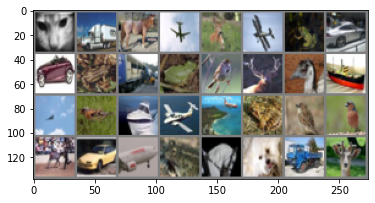


  cat truck horse plane


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random images
dataiter = iter(testloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

2. Define a Convolutional Neural Network
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^



In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


Upload the cifar_net.pth file before running the next command.

In [ ]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1QR4RUh0XmSMHBJ7U0N3EfGO8HYFnJozz' -O ./cifar_net.pth

--2020-07-16 19:30:21--  https://docs.google.com/uc?export=download&id=1QR4RUh0XmSMHBJ7U0N3EfGO8HYFnJozz
Resolving docs.google.com (docs.google.com)... 172.217.212.102, 172.217.212.100, 172.217.212.113, ...
Connecting to docs.google.com (docs.google.com)|172.217.212.102|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0g-4c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/5c82qqqtjgku61hjltsspnjcgh7c77eu/1594927800000/08580301896634903192/*/1QR4RUh0XmSMHBJ7U0N3EfGO8HYFnJozz?e=download [following]
--2020-07-16 19:30:21--  https://doc-0g-4c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/5c82qqqtjgku61hjltsspnjcgh7c77eu/1594927800000/08580301896634903192/*/1QR4RUh0XmSMHBJ7U0N3EfGO8HYFnJozz?e=download
Resolving doc-0g-4c-docs.googleusercontent.com (doc-0g-4c-docs.googleusercontent.com)... 108.177.112.132, 2607:f8b0:4001:c12::84
Connecting to doc-0g-4c-docs.googleusercontent.com (doc-0g

In [ ]:
net = Net()
PATH = './cifar_net.pth'
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

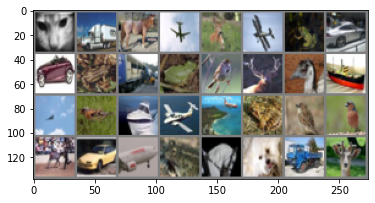

GroundTruth:    cat truck horse plane  deer plane  frog   car   car  frog truck  frog  bird  deer  bird  ship plane  bird  ship plane plane  frog  bird  bird horse   car plane  frog horse   dog truck  deer
Predicted:    cat  ship   dog plane  deer plane  bird   car   cat  frog   cat  frog   dog plane   dog  ship plane  deer  ship plane plane  frog  bird  deer horse   car   cat  frog   dog   dog   car  deer


In [ ]:
outputs = net(images)
_, predicted = torch.max(outputs, 1)

imshow(torchvision.utils.make_grid(images.detach()))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(len(images))))
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]for j in range(len(predicted))))

Filter the images based on correct predictions

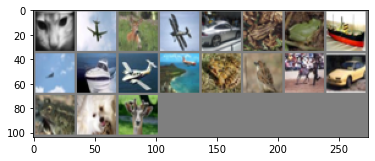

GroundTruth:    cat plane  deer plane   car  frog  frog  ship plane  ship plane plane  frog  bird horse   car  frog   dog  deer


In [ ]:
vimages=images[labels==predicted]
vlabels=labels[labels==predicted]

imshow(torchvision.utils.make_grid(vimages.detach()))
print('GroundTruth: ', ' '.join('%5s' % classes[vlabels[j]] for j in range(len(vimages))))


A utility function for plotting the effect of the direction vector in the input space on the output classification

In [ ]:
def morph(net,base,direction,range=range(0,25),targetclass=None):
  basecls = torch.max(net(base.unsqueeze(0)), 1)[1][0]
  timages=[]
  for e in range:
    ti = np.expand_dims(base.detach()-e*direction,axis=0)
    timages.append(ti)
  timages=torch.from_numpy(np.concatenate(timages)).float()
  toutputs=net(timages)
  _, tpredicted = torch.max(toutputs, 1)
  if targetclass is None:
    tflipped=np.where(tpredicted!=basecls)[0]
  else:
    tflipped=np.where(tpredicted==targetclass)[0]   
  tflipped=tflipped[0] if len(tflipped)>0 else -1
  return timages,toutputs,tflipped


def plotMorph(timages,toutputs,tflipped,title):
  plt.figure(figsize=(15,5))
  plt.subplot(131)
  plt.plot(toutputs.detach().numpy())
  plt.gca().legend(classes,loc=4)
  plt.title(title+" flipped {}".format(tflipped))
  plt.subplot(132)
  plt.imshow(np.clip((timages[0].permute(1,2,0)/2.0+0.5),0,1.0))
  plt.subplot(133)
  plt.imshow(np.clip((timages[tflipped].permute(1,2,0)/2.0+0.5),0,1.0))
  plt.show()


First we try the random direction examples

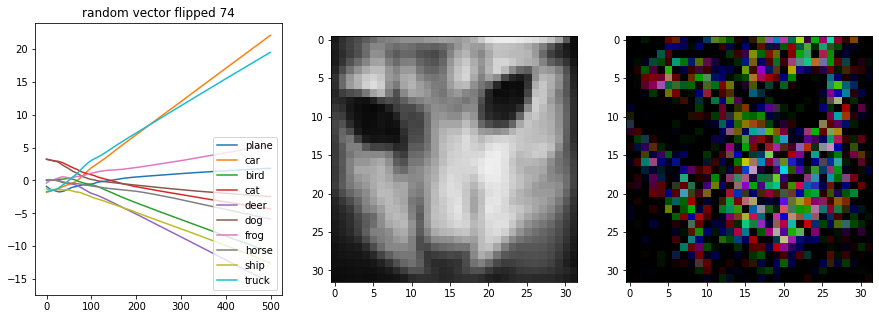

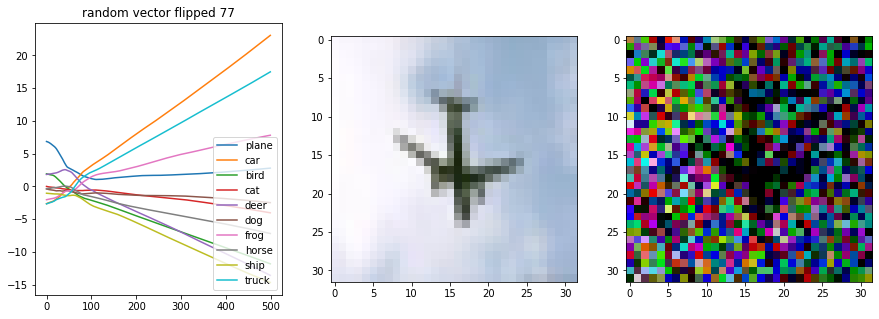

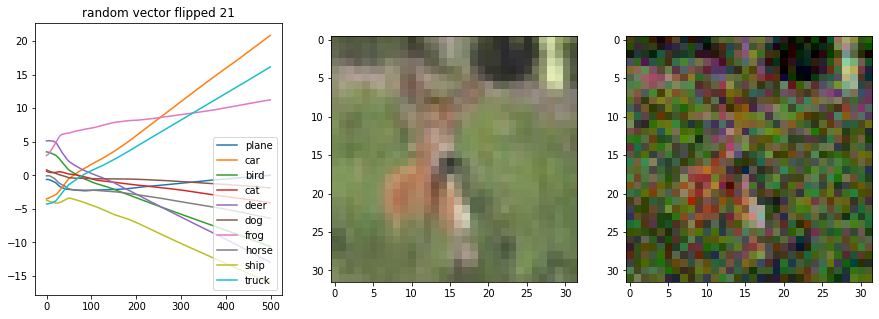

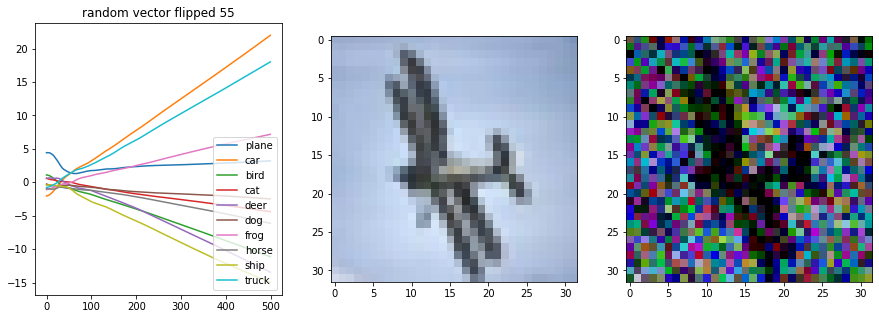

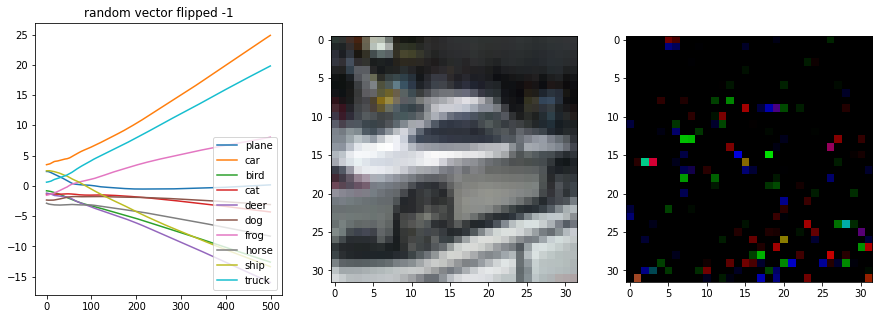

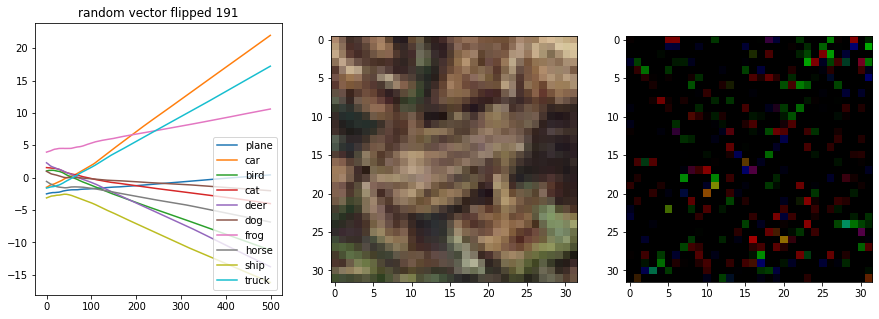

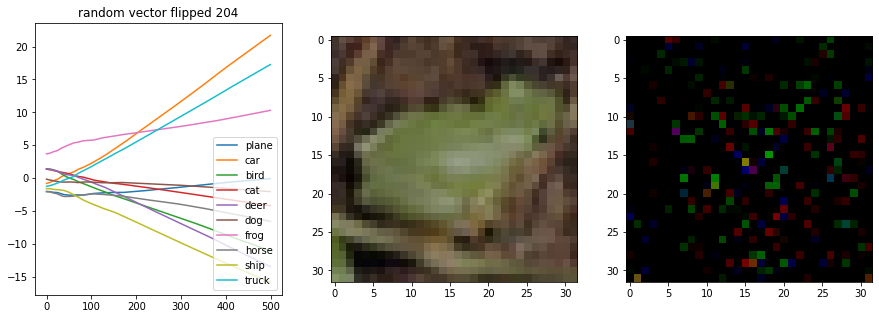

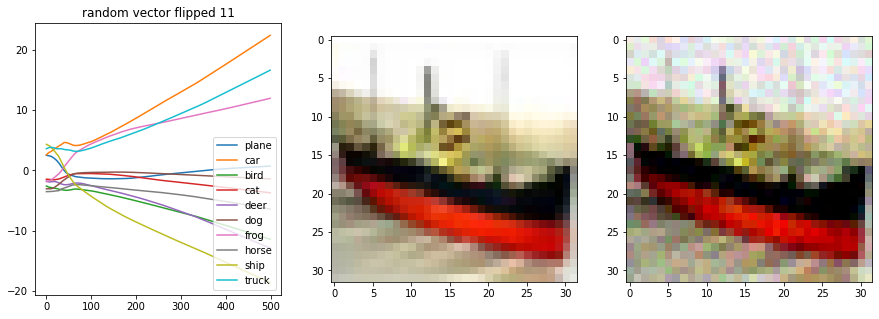

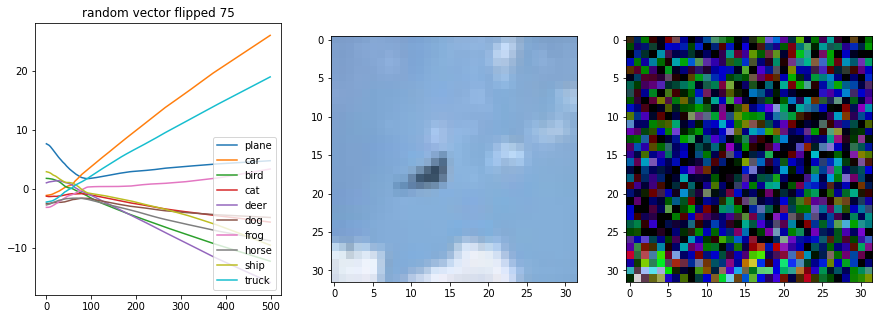

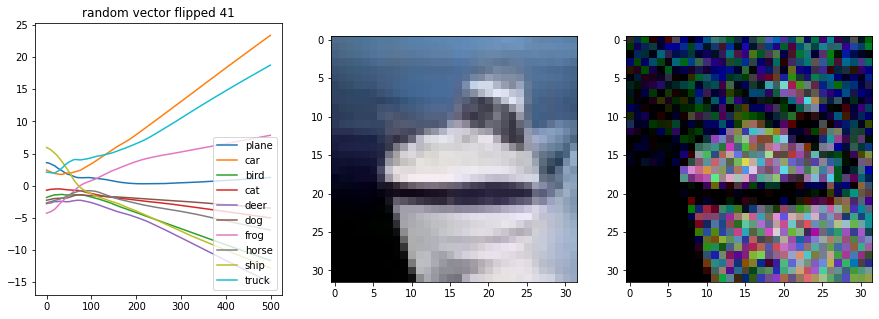

In [ ]:
import random
r1=np.random.rand(*vimages.shape[1:])
r1/= np.linalg.norm(r1)

for base in vimages[:10]:
  plotMorph(*morph(net,base,r1,range(0,500)),"random vector")


Now we pick a vector that is the sign(grad(loss(target))).


In [ ]:
def adv(net,image,tclass):
  bimages=torch.unsqueeze(image.detach(),0)
  bimages.requires_grad=True
  boutputs = net(bimages)
  tcriterion = nn.CrossEntropyLoss()
  tclasst=torch.full((boutputs.shape[0],),tclass,dtype=torch.long)
  losst=tcriterion(boutputs,tclasst)
  losst.backward(retain_graph=True)
  r1=np.sign(bimages.grad[0])
  return r1/np.linalg.norm(r1)

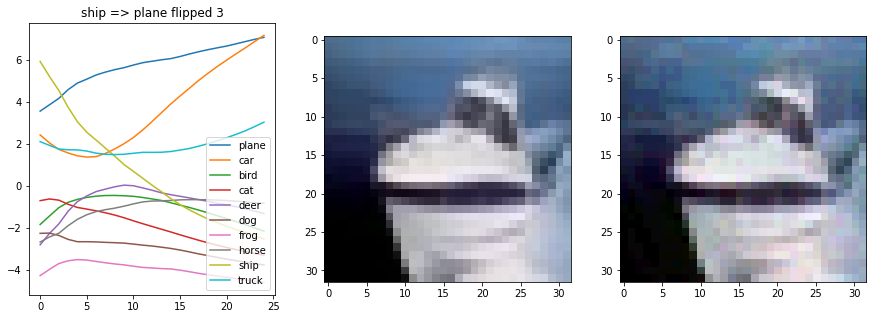

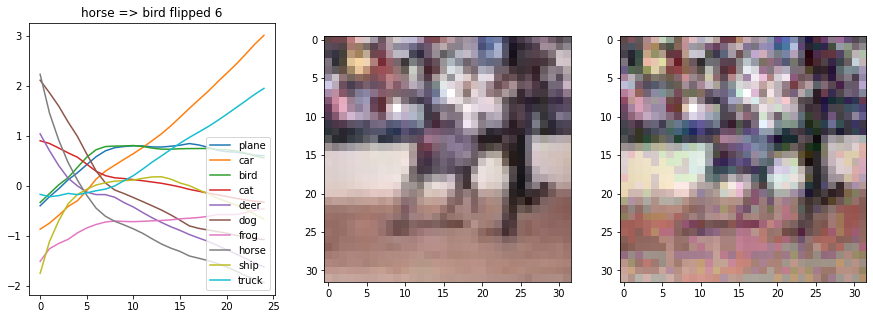

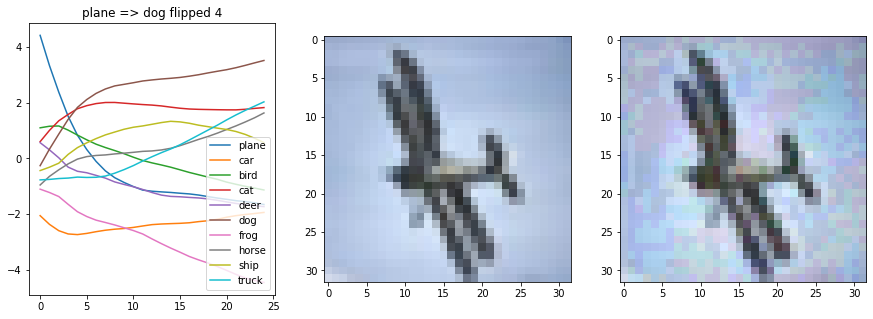

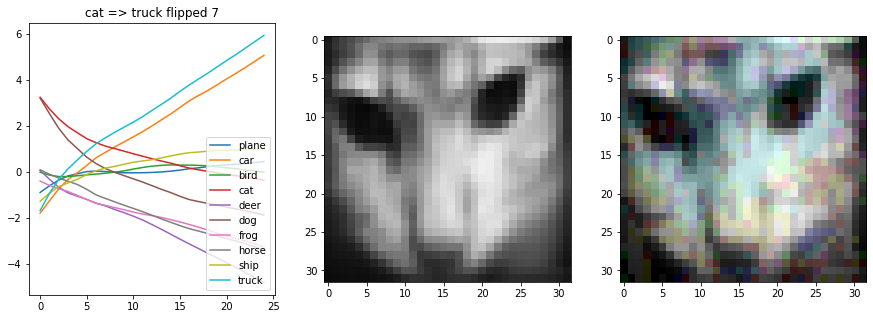

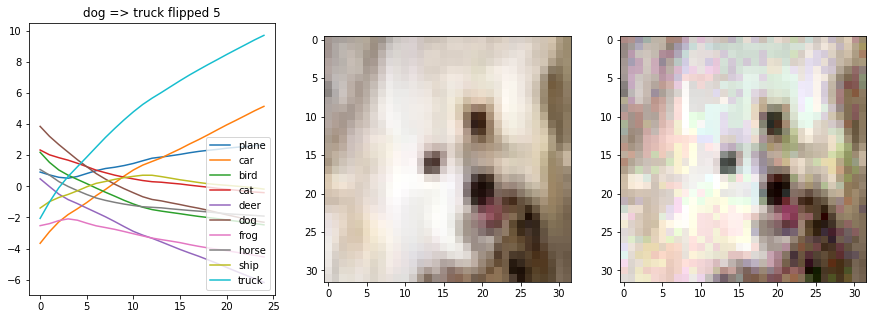

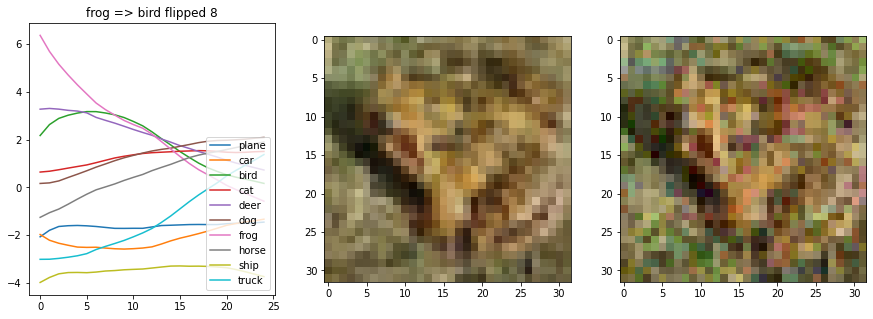

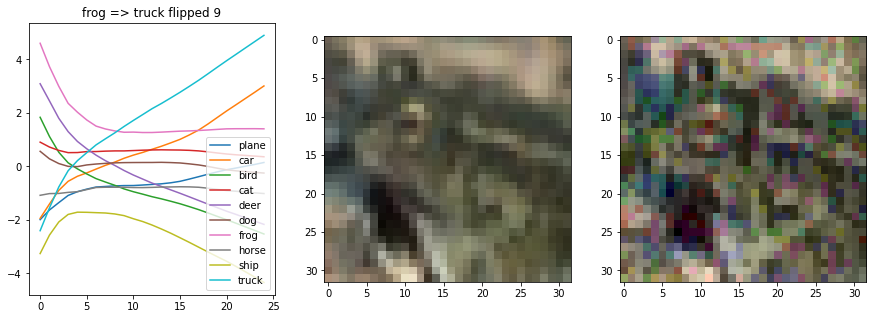

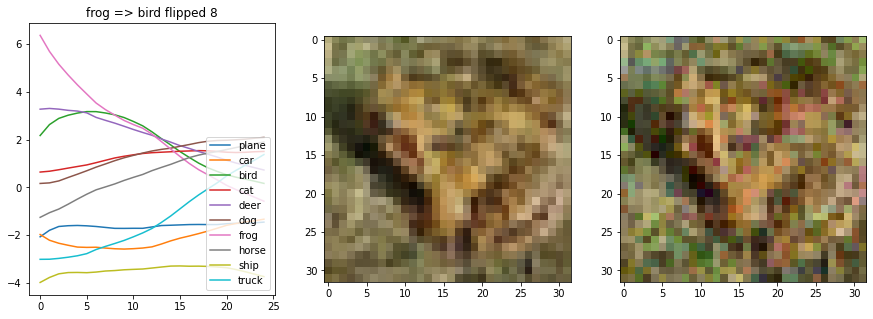

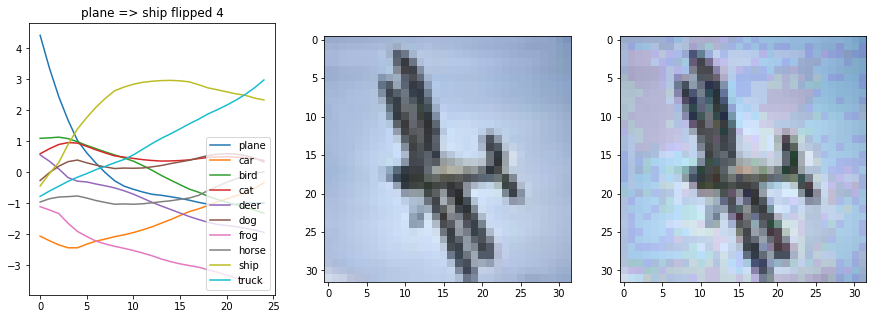

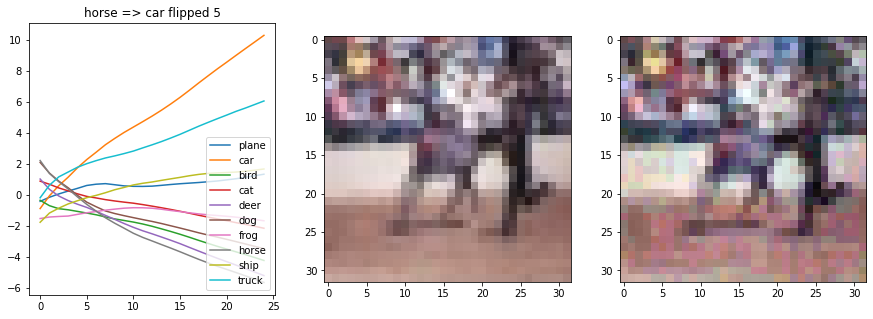

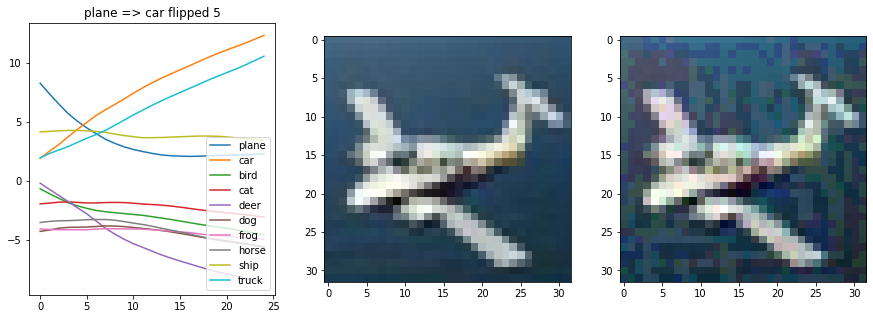

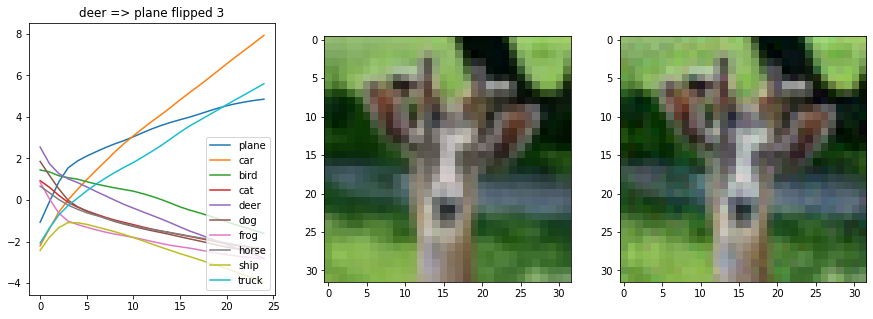

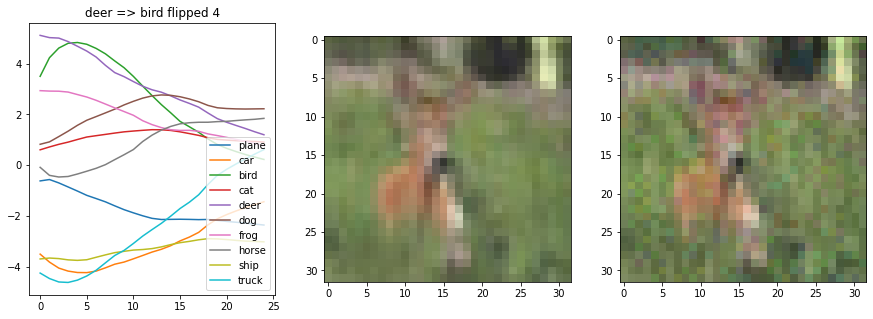

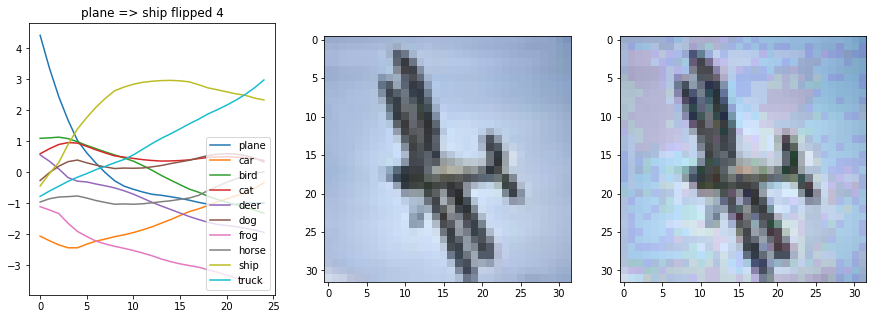

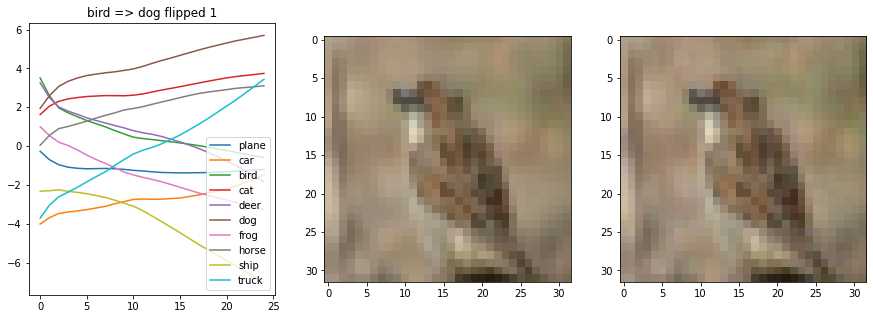

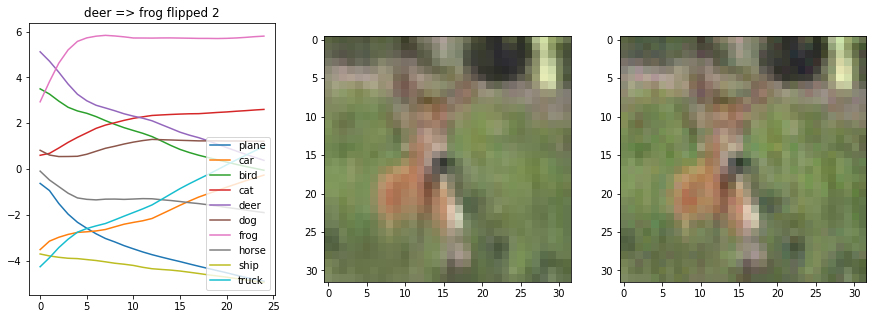

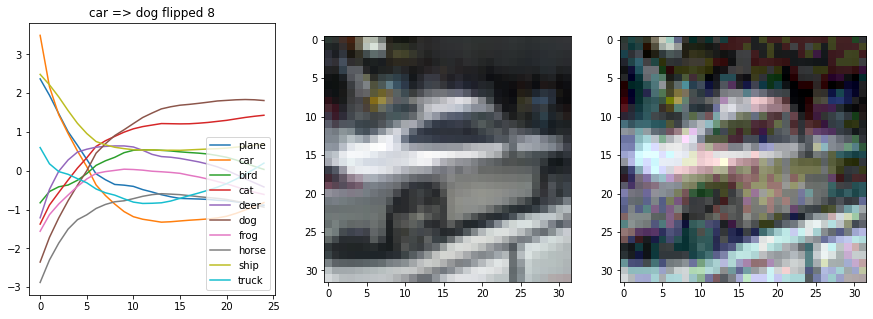

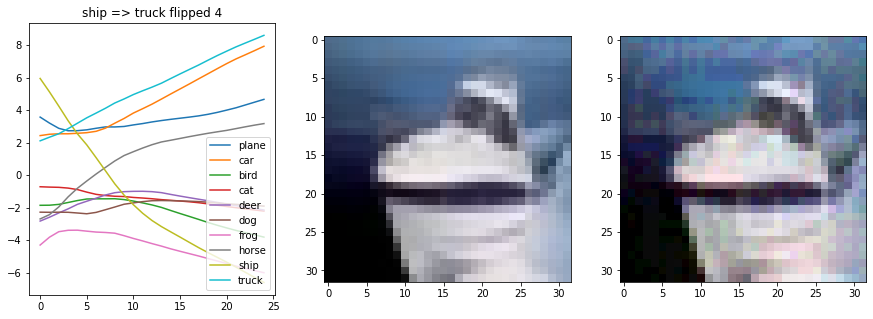

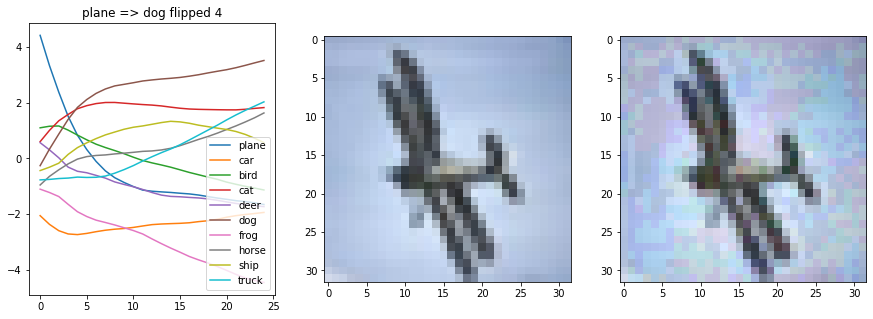

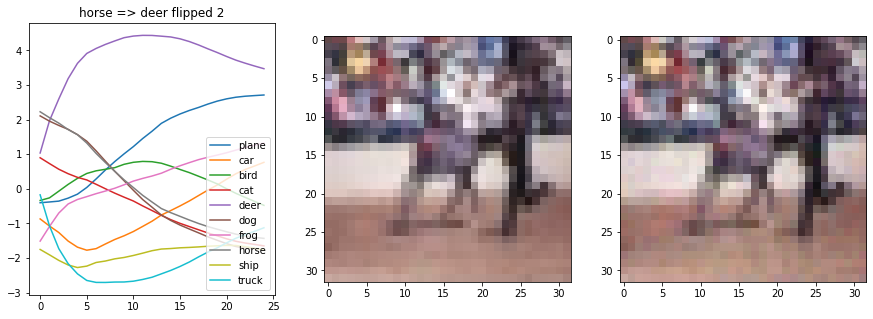

In [ ]:
bases=list(zip(vimages,vlabels))
random.seed(43)
cnt=0
while cnt<20:
  didx=random.randrange(len(classes))
  base,bidx=random.choice(bases)
  direction=adv(net,base,didx)
  m=morph(net,base,direction,range(0,25),targetclass=didx)
  if bidx==didx or  m[2]>10 or m[2]==-1: #skip boring examples
    continue
  plotMorph(*m,"{} => {}".format(classes[bidx],classes[didx]))
  cnt+=1
